In [10]:
%pip install matplotlib
%pip install seaborn
%pip install numpy
%pip install pandas
%pip install math
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency

## Analysis of original data

In [2]:
# Load dataset
train_dir = "train.csv"

# Read the data
train_data = pd.read_csv(train_dir)

In [13]:
# Basic Info
print("Basic Dataset Info:")
print(train_data.info())

Basic Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient  

Bed Grade and City Code Patient have missing values. Some types seem out of place, such as Hospital Code being an int.

In [14]:
# Print missing values
print("\nMissing Values:")
print(train_data.isnull().sum())


Missing Values:
case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64


In [15]:
# Summary Statistics
print("\nSummary Statistics:")
print(train_data.describe())


Summary Statistics:
             case_id  Hospital_code  City_Code_Hospital  \
count  318438.000000  318438.000000       318438.000000   
mean   159219.500000      18.318841            4.771717   
std     91925.276848       8.633755            3.102535   
min         1.000000       1.000000            1.000000   
25%     79610.250000      11.000000            2.000000   
50%    159219.500000      19.000000            5.000000   
75%    238828.750000      26.000000            7.000000   
max    318438.000000      32.000000           13.000000   

       Available Extra Rooms in Hospital      Bed Grade      patientid  \
count                      318438.000000  318325.000000  318438.000000   
mean                            3.197627       2.625807   65747.579472   
std                             1.168171       0.873146   37979.936440   
min                             0.000000       1.000000       1.000000   
25%                             2.000000       2.000000   32847.000000   
50%

## Simple data cleaning (conversions for EDA)

In [3]:
# Drop case_id and patientid
# These are not relevant to our goal
train_data.drop(columns=[col for col in ['case_id', 'patientid'] if col in train_data.columns], inplace=True)

In [4]:
# Convert code numbers to string objects
categorical_codes = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Department', 'Ward_Facility_Code', 'Hospital_region_code', 'Ward_Type', 'City_Code_Patient']
for col in categorical_codes:
    if col in train_data.columns:
        if col == 'City_Code_Patient':  # Ensure NaN values are preserved
            train_data[col] = train_data[col].astype(str).replace('nan', np.nan)
        else:
            train_data[col] = train_data[col].astype(str)

In [5]:
# Convert these to numeric values now to utilize in numerical correlation calculations
if 'Type of Admission' in train_data.columns:
    admission_mapping = {'Trauma': 0, 'Urgent': 1, 'Emergency': 2}
    train_data['Type of Admission'] = train_data['Type of Admission'].map(admission_mapping)

if 'Severity of Illness' in train_data.columns:
    severity_mapping = {'Minor': 0, 'Moderate': 1, 'Extreme': 2}
    train_data['Severity of Illness'] = train_data['Severity of Illness'].map(severity_mapping)

In [6]:
# Categorize Stay column
stay_mapping = {
    '0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4,
    '51-60': 5, '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9,
    '100 Days': 9, 'More than 100 Days': 10
}
train_data['Stay'] = train_data['Stay'].map(stay_mapping)

In [7]:
# Categorize Age column
age_mapping = {
    '0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4,
    '51-60': 5, '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9,
}
train_data['Age'] = train_data['Age'].map(stay_mapping)

## Analysis of Cleaned Data Overall

In [21]:
# Basic Info
print("Basic Dataset Info:")
print(train_data.info())

Basic Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 16 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Hospital_code                      318438 non-null  object 
 1   Hospital_type_code                 318438 non-null  object 
 2   City_Code_Hospital                 318438 non-null  object 
 3   Hospital_region_code               318438 non-null  object 
 4   Available Extra Rooms in Hospital  318438 non-null  int64  
 5   Department                         318438 non-null  object 
 6   Ward_Type                          318438 non-null  object 
 7   Ward_Facility_Code                 318438 non-null  object 
 8   Bed Grade                          318325 non-null  float64
 9   City_Code_Patient                  313906 non-null  object 
 10  Type of Admission                  318438 non-null  int64  
 11  Severity of Illness

In [22]:
train_data.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,c,3,Z,3,radiotherapy,R,F,2.0,7.0,2,2,2,5,4911.0,0
1,2,c,5,Z,2,radiotherapy,S,F,2.0,7.0,0,2,2,5,5954.0,4
2,10,e,1,X,2,anesthesia,S,E,2.0,7.0,0,2,2,5,4745.0,3
3,26,b,2,Y,2,radiotherapy,R,D,2.0,7.0,0,2,2,5,7272.0,4
4,26,b,2,Y,2,radiotherapy,S,D,2.0,7.0,0,2,2,5,5558.0,4


## EDA Against Stay: All Numerical Values

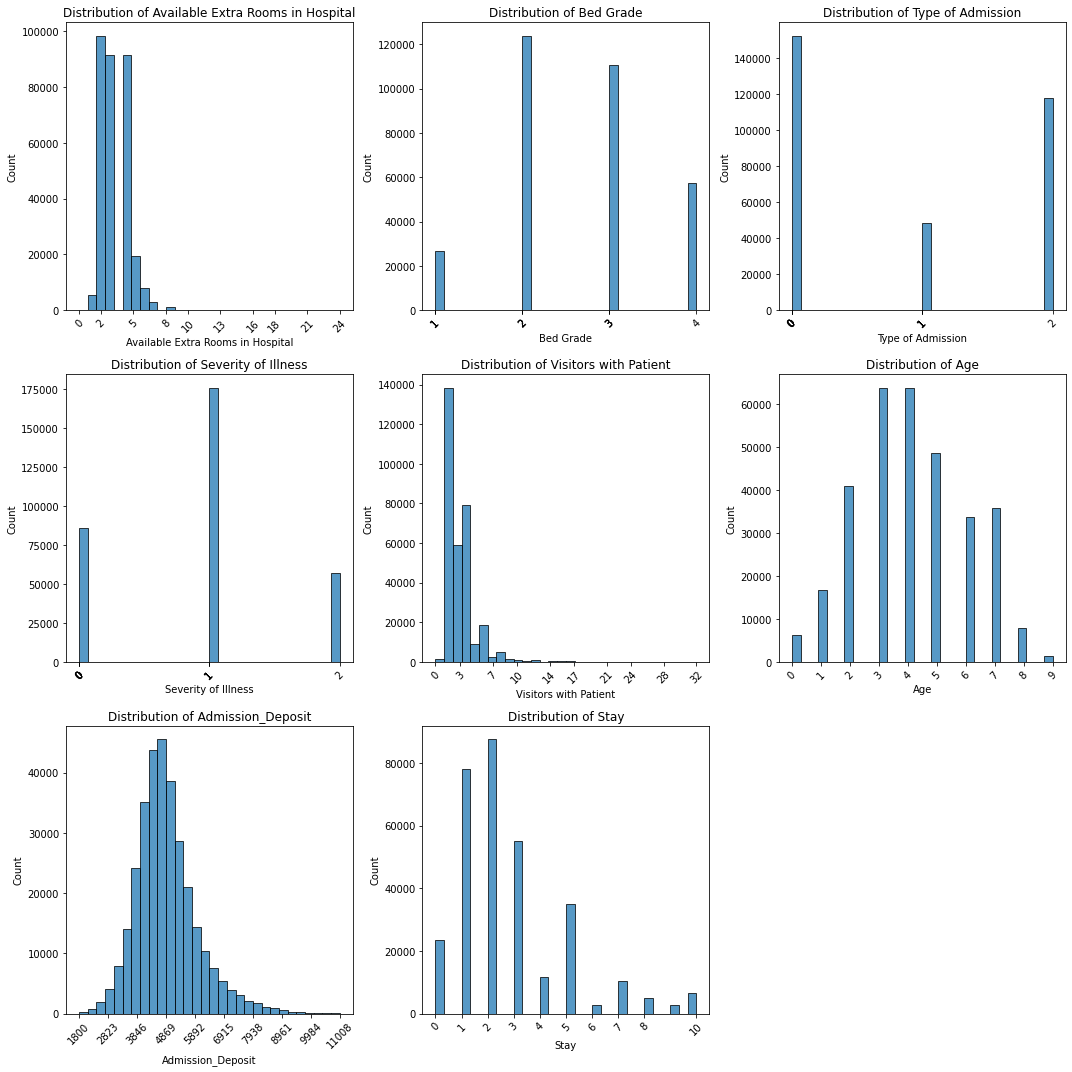

In [23]:
# Select numerical columns
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_features = len(num_cols)
rows = math.ceil(num_features / 3)

# Set figure size
plt.figure(figsize=(15, 5 * rows))

# Loop through numerical columns and plot distributions
for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, 3, i)
    sns.histplot(train_data[col], bins=30, kde=False)  # Ensure 30 bars
    plt.title(f'Distribution of {col}')
    
    # Get min and max values for x-axis
    col_min, col_max = train_data[col].min(), train_data[col].max()
    
    # Ensure 10 evenly spaced ticks on the x-axis
    tick_values = np.linspace(col_min, col_max, num=10, dtype=int)
    plt.xticks(tick_values, fontsize=10, rotation=45)

plt.tight_layout()
plt.show()

Understanding the distribution is essential for us to realize the data is heavily imbalanced, and we must consider this carefully. Interestingly, admission deposit has a positive skew bell curve, and age and bed grade have bell curve-like distributions as well. While most patients face 0-6 extra available rooms or 0-12 vistors in the hospital, there are a few outliers going up to 24 extra rooms or 32 visitors, respectively. None of the columns have even distributions.

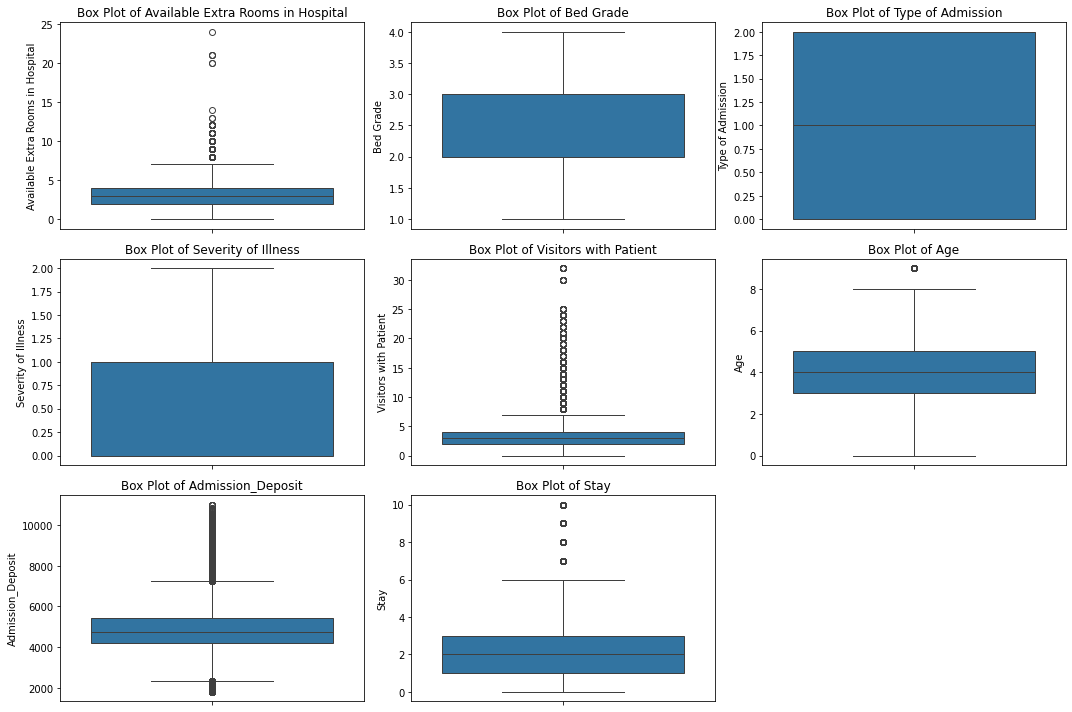

In [24]:
# Box Plots for Outlier Detection
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=train_data[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

Extra Rooms, Visitors, Admission Deposit, and Stay have outliers as they are concentrated in low amounts, but have a few high outliers. Bed Grade and Admission Type are more balanced. The stretchness of severity shows diversity. Age is well spread except for a single outlier

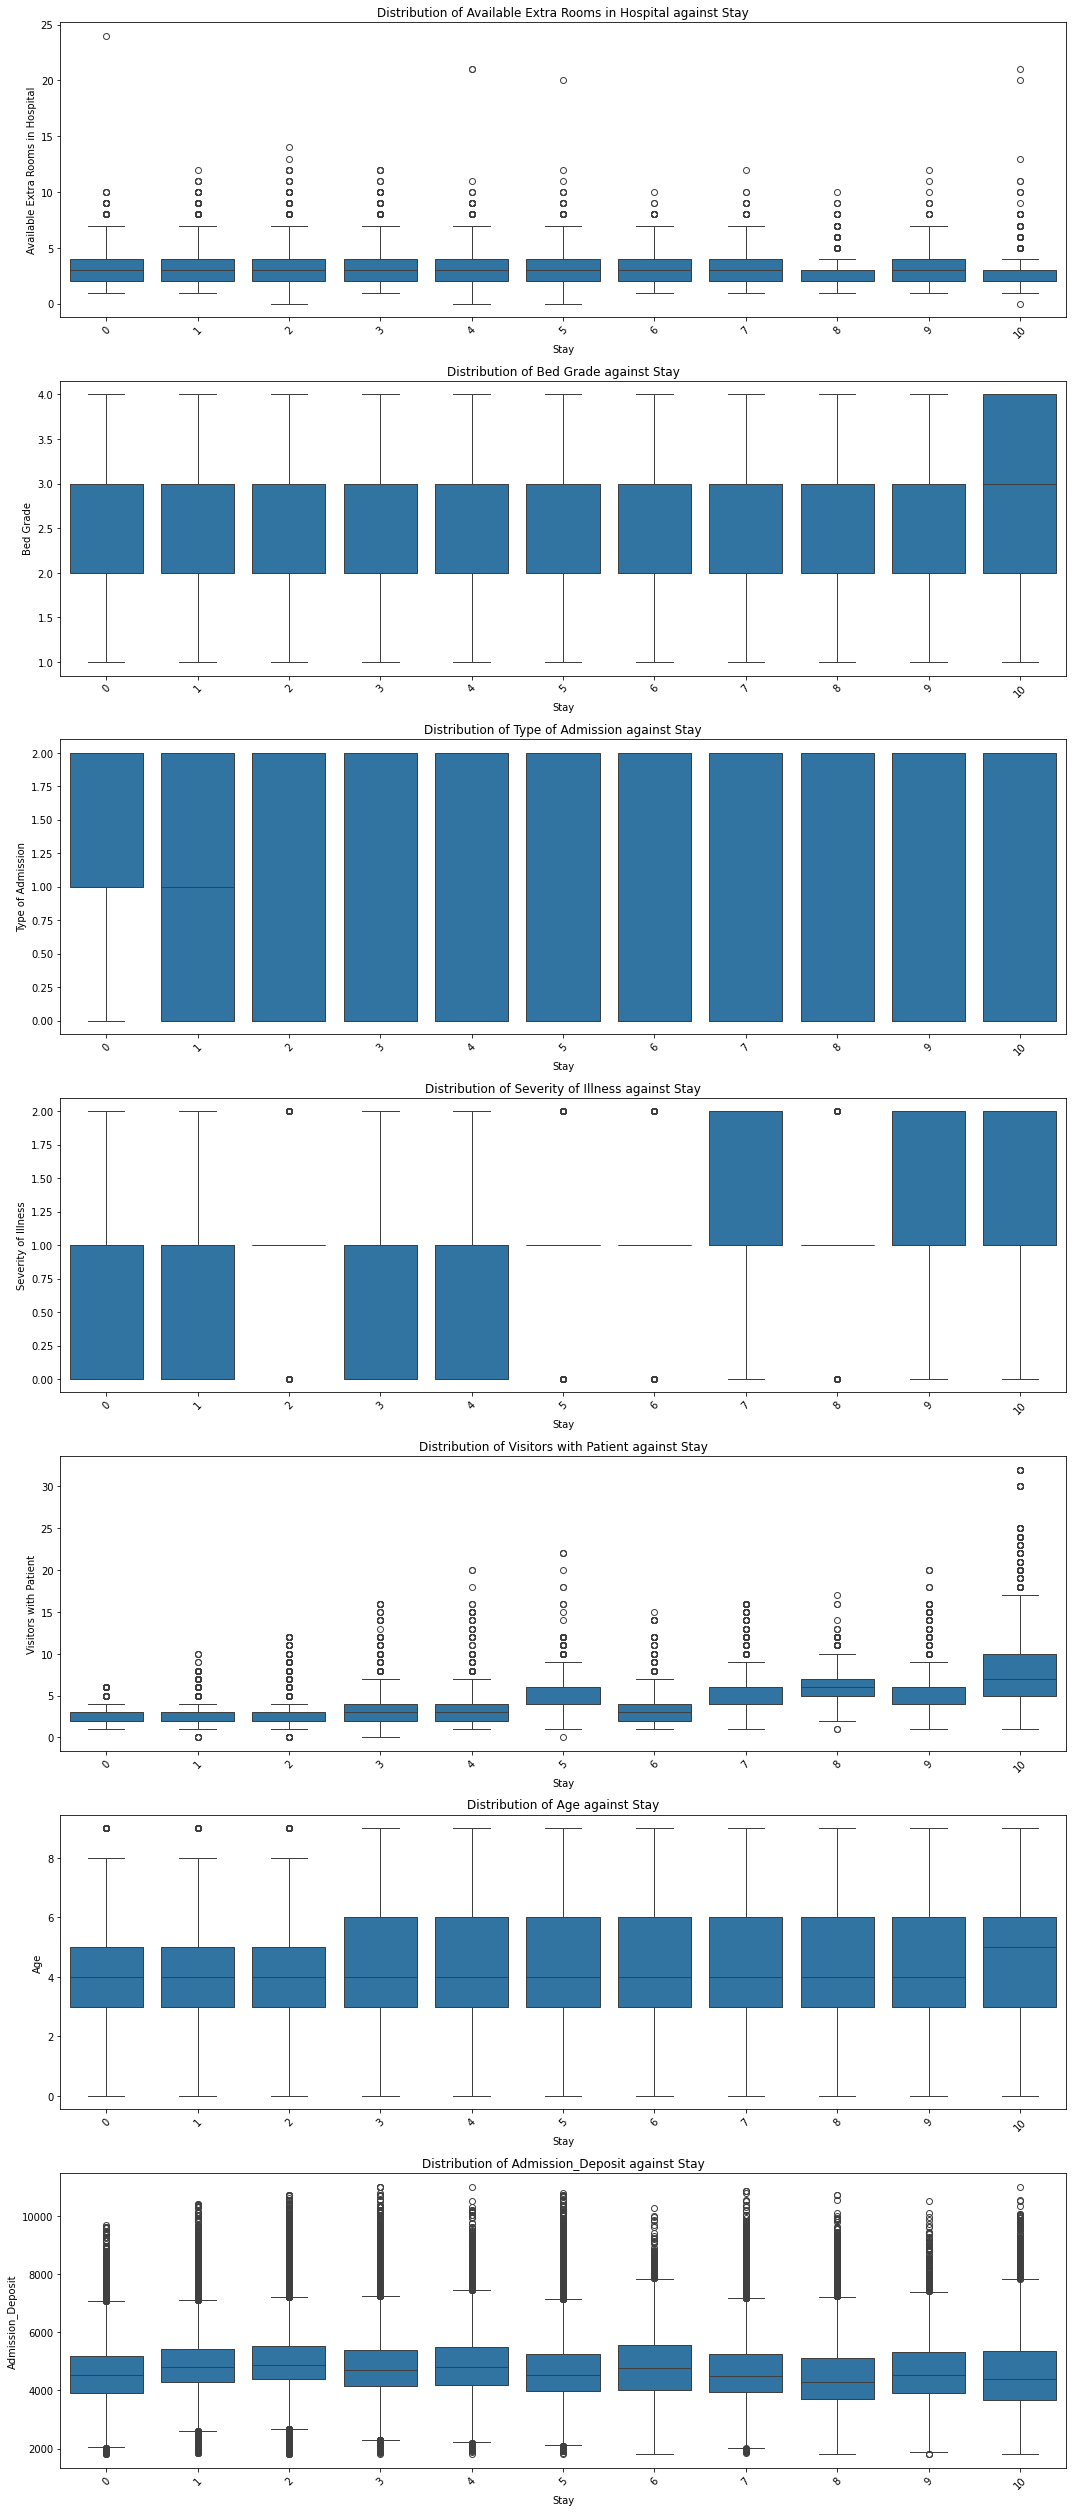

In [25]:
# Get numerical columns but exclude 'Stay'
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [col for col in num_cols if col != 'Stay']  # Exclude Stay

# Plot box plots for each numerical column against 'Stay'
plt.figure(figsize=(15, 5 * len(num_cols)))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.boxplot(x=train_data['Stay'], y=train_data[col])
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col} against Stay')

plt.tight_layout()
plt.show()

The distribution of Available Extra Rooms remains stable across different Stay lengths, suggesting that the number of available rooms does not significantly impact the length of hospitalization.

While Bed Grade and Type of Admission mostly show moderate distributions, there is some variability. Notably, patients with the longest stays tend to have higher Bed Grades, potentially indicating that patients who stay longer require higher-quality beds. Additionally, Emergency and Urgent admissions are more common for shorter stays compared to Trauma admissions, suggesting that trauma patients may have the shortest hospitalization periods.

The relationship between Severity of Illness and Stay is not entirely consistent, but a trend emerges: minor cases tend to have shorter stays, extreme cases are more common in longer hospital stays, and moderate severity cases do not show a clear trend, possibly indicating a more variable recovery period.

The Number of Visitors generally increases with longer hospital stays, though some fluctuations in the trend are present. The median Age remains fairly constant at 4 across different Stay lengths, except for an increase to 5 in the longest stays. This suggests little correlation between Age and Stay, despite a slight increase in the upper quartile (Q4). However, Age = 4 decades has the most values, making it understandable why it may appear the highest throughout.

Finally, Admission Deposit does not show a clear linear relationship with Stay, displaying a fluctuating pattern instead, indicating no strong correlation.

Furthermore, Available Rooms, Visitors, and Admission Deposit tend to have many high outliers, skewing the data.

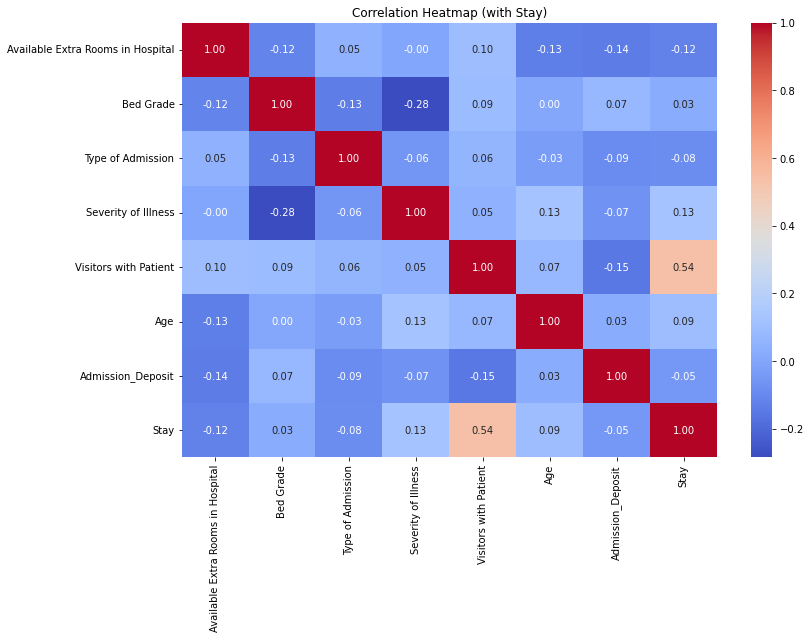

In [26]:
# Compute correlation matrix including Stay
numeric_train_data = train_data.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12, 8))
corr_matrix = numeric_train_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (with Stay)')
plt.show()

We can see that Visitors have the highest correlation against Stay with 0.54, suggesting influence. Severity of Illness has mild correlation with Bed Grade. Besides these, other values have little correlation. We are focused on Stay, but most attributes besides Visitor with Patients have absolute values of correlations less than 0.14.

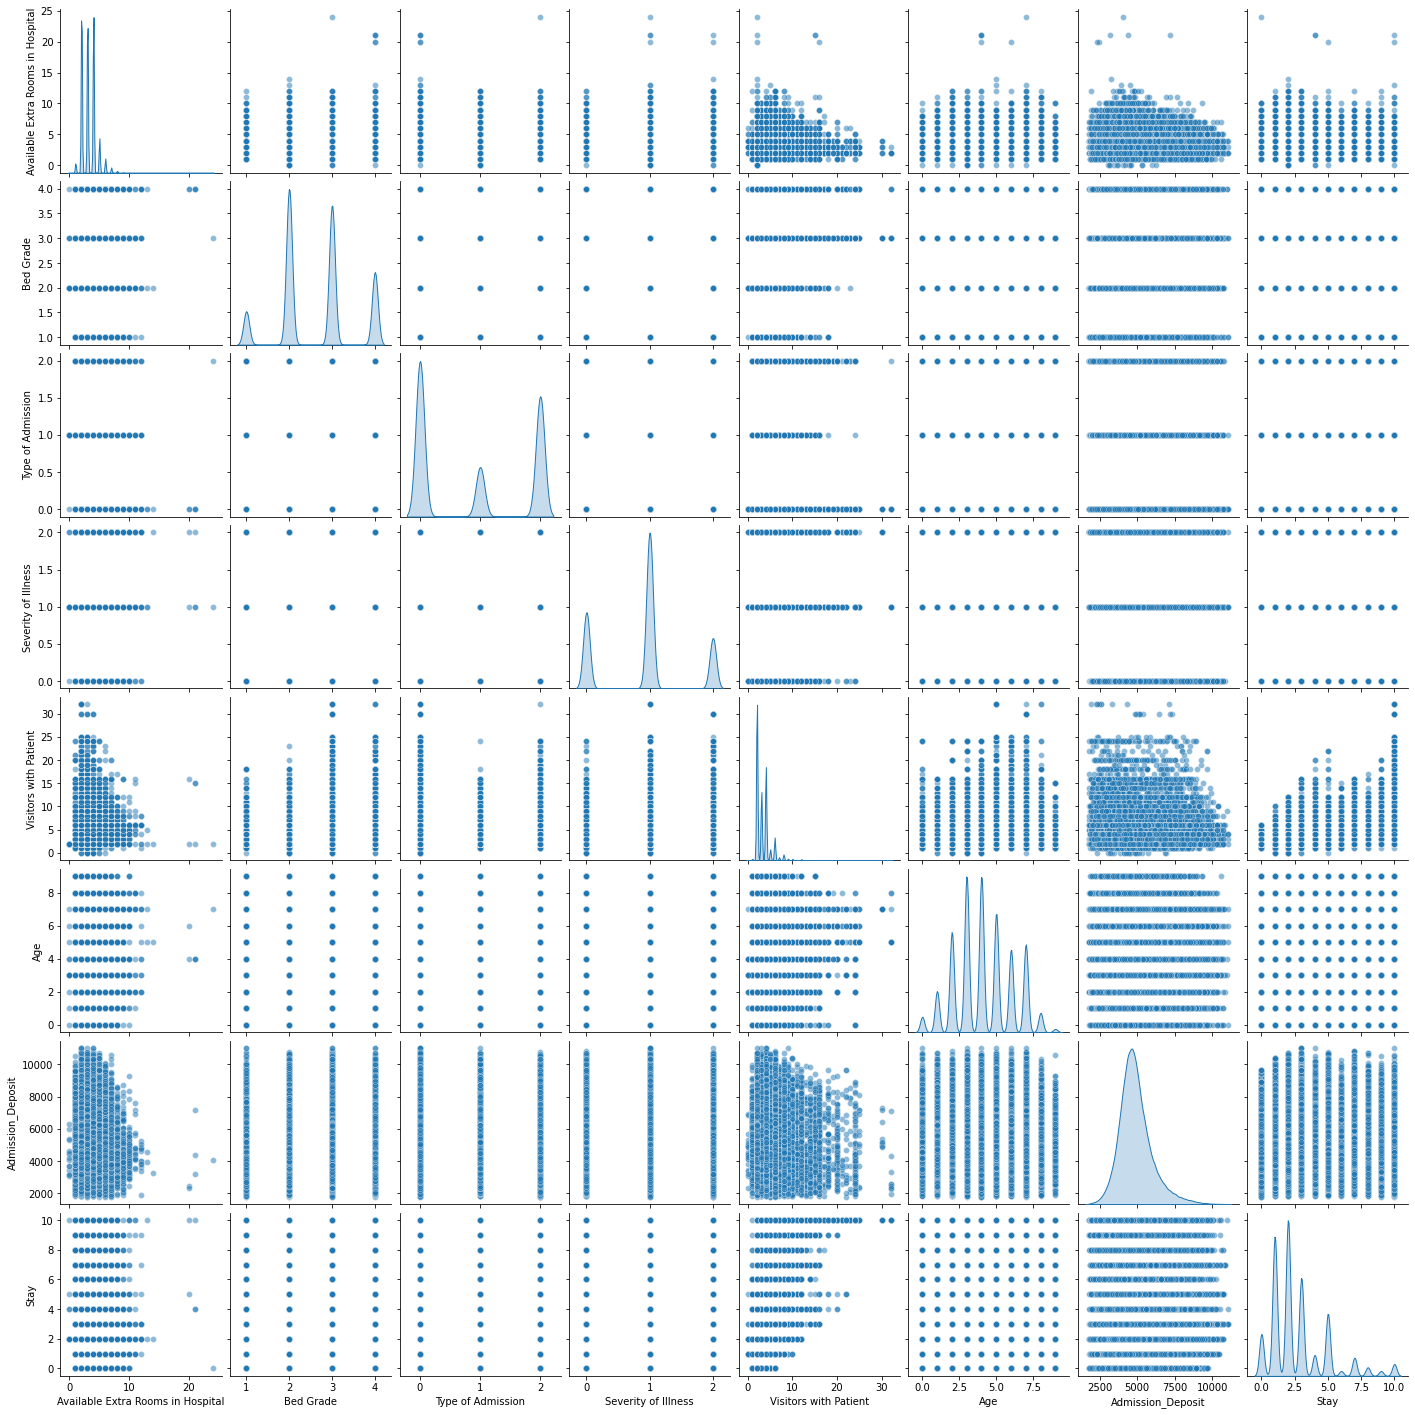

In [27]:
# Generate pairplot for all numerical variables including Stay
sns.pairplot(numeric_train_data, diag_kind="kde", plot_kws={'alpha': 0.5})
plt.show()

Most pairplots demonstrate even distrbution between pairs of data, with some having outliers, suggesting little correlation. There are some with slight correlation though.

Visitors with Patient tend to increase with a longer stay in a bimodal distrbution, and Stay = 10 has a few outliers (that are not too far off because it was already high), further reinforcing the relatively high correlation between Age and Stay.

Patients in a hospital with less extra beds tend to have more patients sometimes, while the occurances with many extra rooms have few patients. Patients with higher bed grades tend to have more visitors with patients. Patients suffering from a Emergency Admission tend to have fewer patients than the other types.

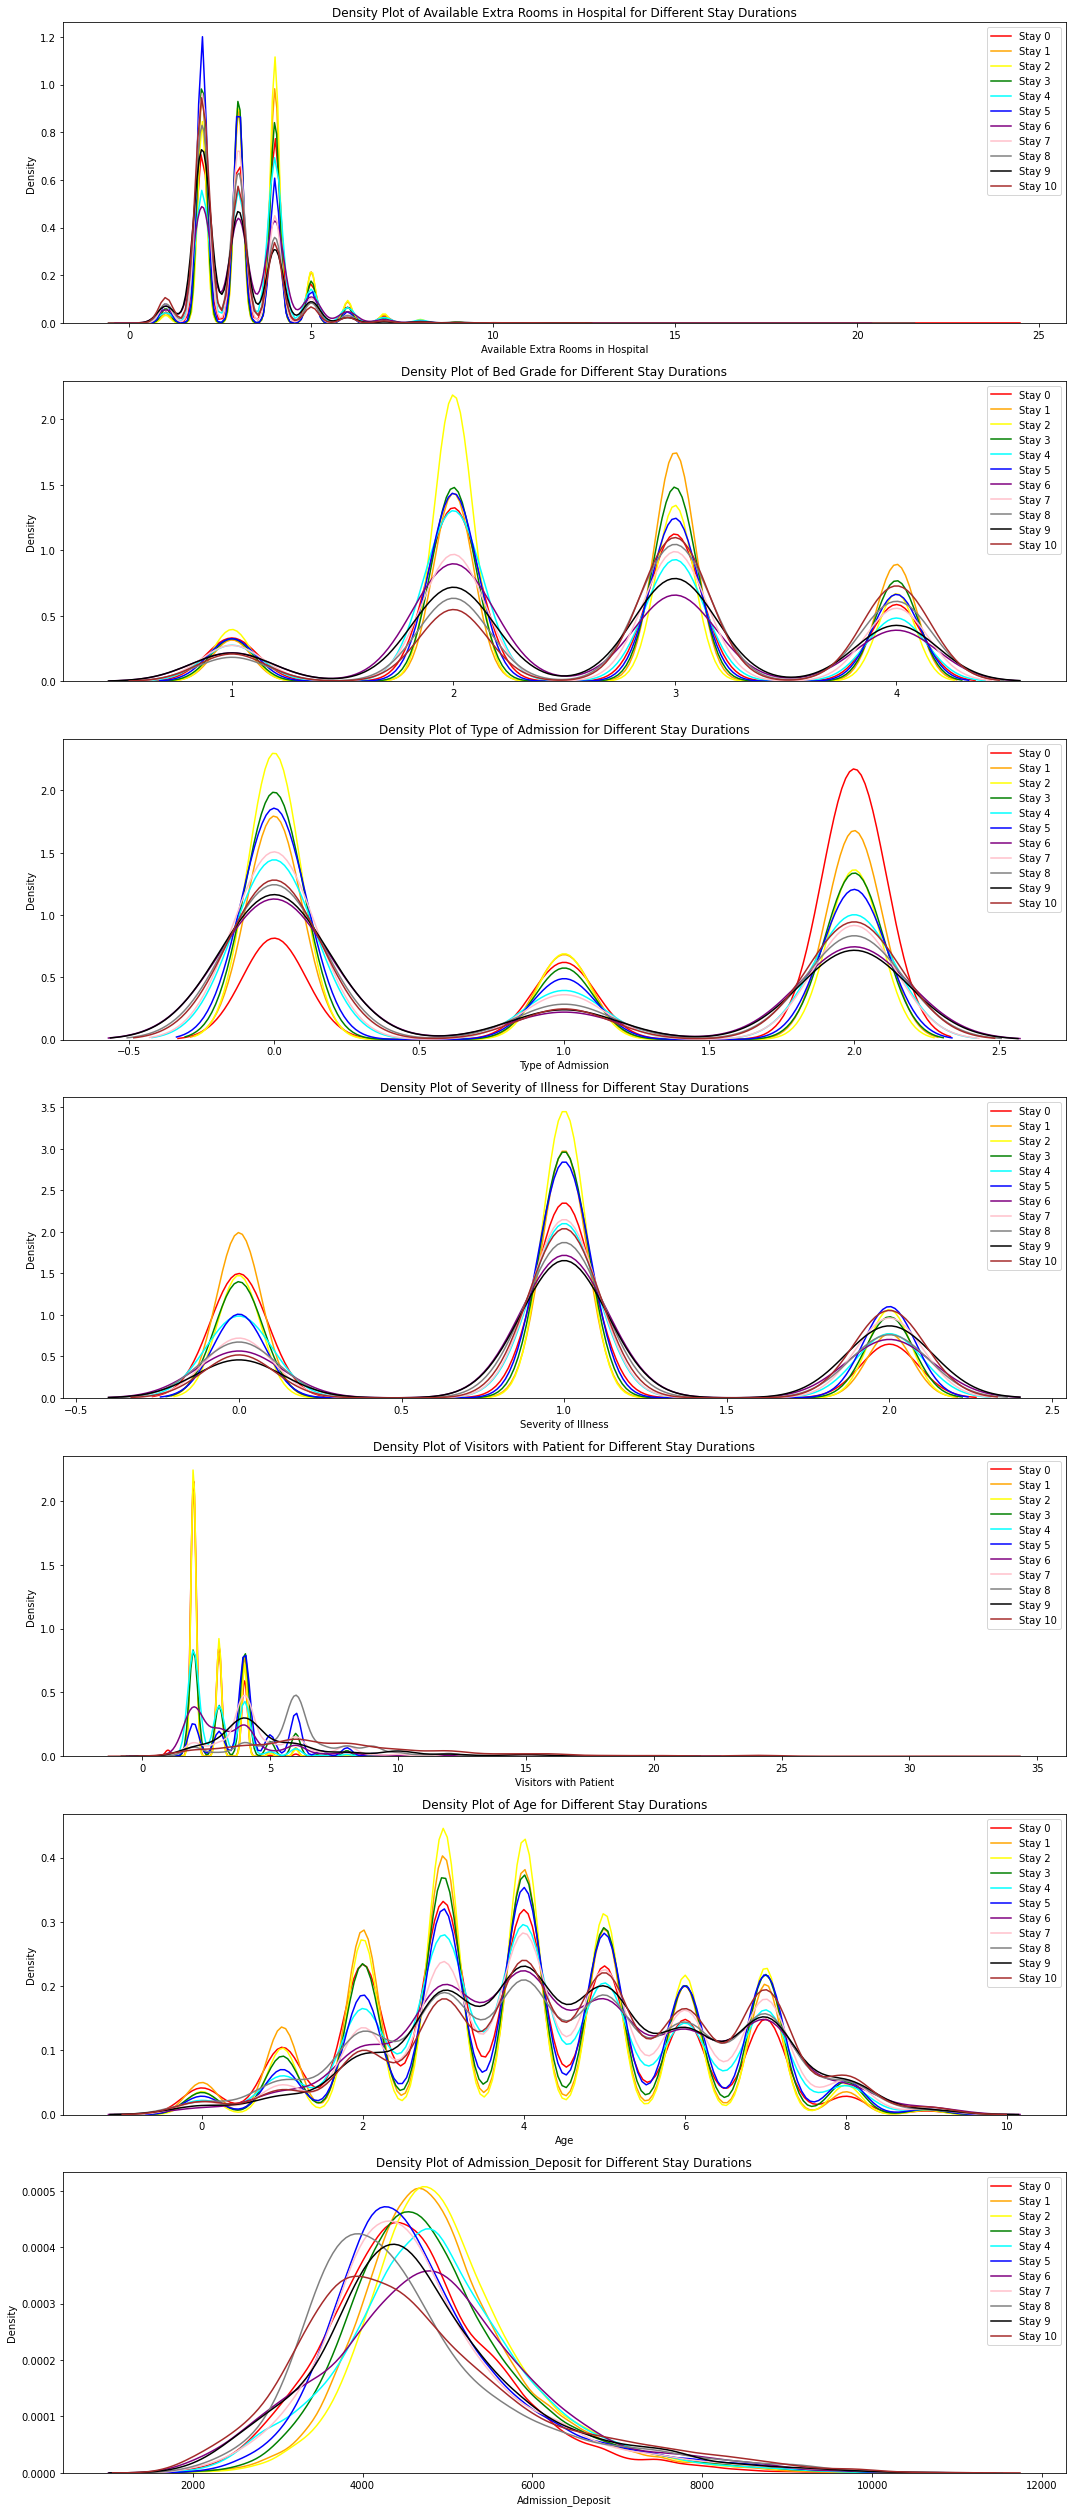

In [28]:
# Define a specific color for each Stay value (0-10)
custom_palette = {
    0: "red",
    1: "orange",
    2: 'yellow',
    3: "green",
    4: "cyan",
    5: "blue",
    6: "purple",
    7: "pink",
    8: "gray",
    9: "black",
    10: "brown"
}

# KDE plots to visualize density distribution of numerical features by Stay
plt.figure(figsize=(15, 5 * len(num_cols)))

for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)

    # Get sorted Stay values
    stay_values = sorted(train_data['Stay'].unique())

    for stay_val in stay_values:
        subset = train_data[train_data['Stay'] == stay_val]

        # Use the predefined color for each Stay value
        color = custom_palette.get(stay_val, "black")  # Default to black if undefined

        sns.kdeplot(subset[col], label=f'Stay {stay_val}', color=color)

    plt.legend()
    plt.title(f'Density Plot of {col} for Different Stay Durations')

plt.tight_layout()
plt.show()

There does not appear to be a significant relationship between Stay and Available Extra Rooms, Bed Grade, Severity of Illness, Age, and Admission Deposit. Age and Admission Deposit, in particular, show a somewhat uniform distribution across different Stay types, indicating that neither factor strongly influences how long a patient remains hospitalized.

Type of Admission shows some correlation with Stay duration, with Stay = 2 having lower values for Type of Admission and Stay = 0 having higher values. Interestingly, Type of Admission = 2 (Urgent) follows a pattern where the colors in the density plot align with the key, meaning that shorter stays are more concentrated in urgent admissions. This suggests that Urgent admissions likely lead to shorter hospital stays, possibly because these cases require immediate attention and are quickly resolved. However, it’s important not to focus too much on a single admission type since Stay data is right-skewed, meaning that shorter stays are far more common overall.

Visitors with Patient appears to have some significance. Stay = 10 is responsible for most outliers, indicating that shorter stays often involve a high number of visitors. Patients with 9 or more visitors (ranging from 9 to 15) tend to have stays between 6 and 9 periods, reinforcing the idea that longer hospitalizations correlate with more visitors. Additionally, Stay = 1 and Stay = 2 peak at lower visitor numbers, suggesting that shorter stays are often associated with fewer visitors.

In [29]:
def plot_numeric_proportion(train_data, numeric_col):
    if numeric_col not in train_data.columns:
        print(f"Column '{numeric_col}' not found in dataset.")
        return
    
    # Check if the column has less than 11 unique values
    unique_values = train_data[numeric_col].nunique()
    if unique_values >= 11:
        print(f"Column '{numeric_col}' has {unique_values} unique values, which is too many for categorical-style plotting. Exiting function.")
        return

    # Compute proportions (normalize=True gives percentages)
    numeric_counts = train_data.groupby("Stay")[numeric_col].value_counts(normalize=True).unstack() * 100

    # Sort the column values numerically
    sorted_order = sorted(numeric_counts.columns)
    numeric_counts = numeric_counts[sorted_order]

    # Plot stacked bar chart
    plt.figure(figsize=(10, 6))
    numeric_counts.plot(kind='bar', stacked=True, color=sns.color_palette("pastel"), figsize=(10, 6))
    
    # Formatting
    plt.title(f"Percentage Distribution of {numeric_col} by Stay")
    plt.xlabel("Stay Duration")
    plt.ylabel("Percentage of Total Stay")
    plt.legend(title=numeric_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    
    # Show plot
    plt.show()

Column 'Available Extra Rooms in Hospital' has 18 unique values, which is too many for categorical-style plotting. Exiting function.


<Figure size 720x432 with 0 Axes>

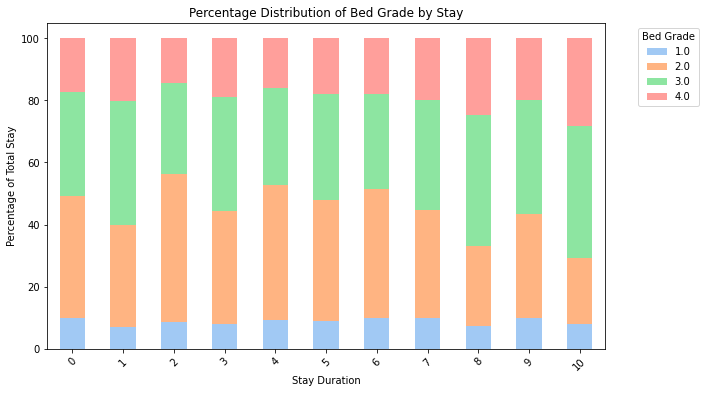

<Figure size 720x432 with 0 Axes>

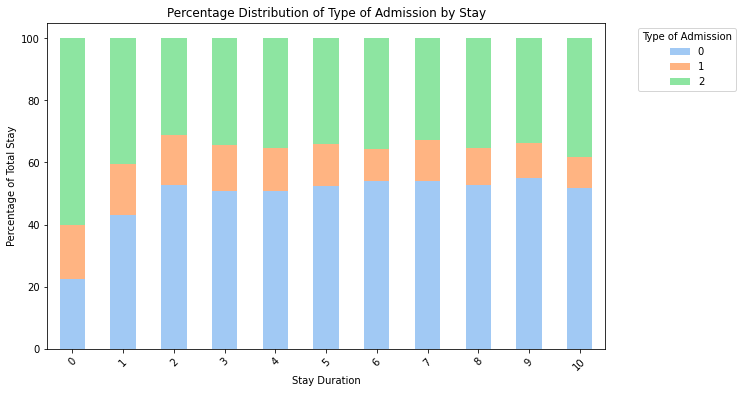

<Figure size 720x432 with 0 Axes>

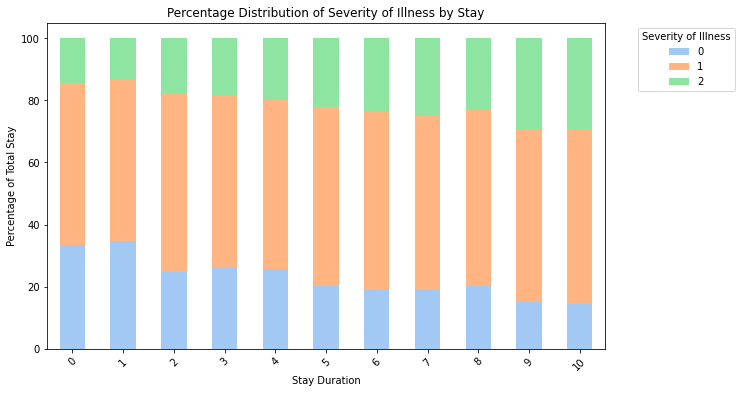

Column 'Visitors with Patient' has 28 unique values, which is too many for categorical-style plotting. Exiting function.


<Figure size 720x432 with 0 Axes>

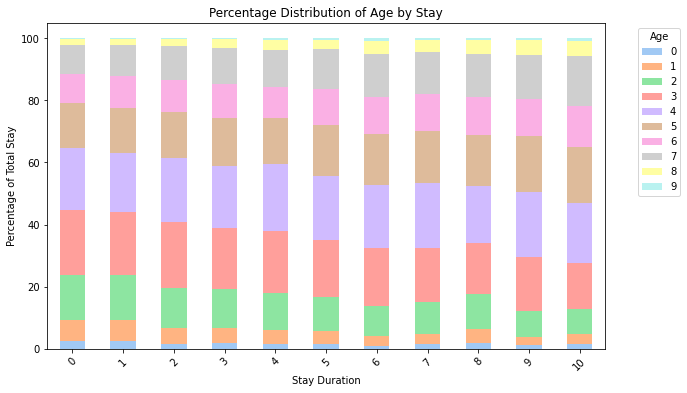

Column 'Admission_Deposit' has 7300 unique values, which is too many for categorical-style plotting. Exiting function.
Column 'Stay' has 11 unique values, which is too many for categorical-style plotting. Exiting function.


In [30]:
for col in train_data.select_dtypes(include=['float64', 'int64']).columns:
    plot_numeric_proportion(train_data, col)

There is a slight decrease of length of stay among Minor admission patients and a slight increase among Extreme admission patients. We could conclude there are Minor admission patients tend to have a lower length of stay a little, and Extreme admission patients tend to have a longer length of stay a little. However, because Moderate admission is about the same throughout each level, it is harder to predict length of stay for Moderate admission patients.

The percentage of younger patients decreases, while the percentage of older patients increases as Stay duration increases, vice versa. This indicates older patients tend to stay longer, while younger patients tend to stay shorter.

## EDA Against Stay: All Categorical Values

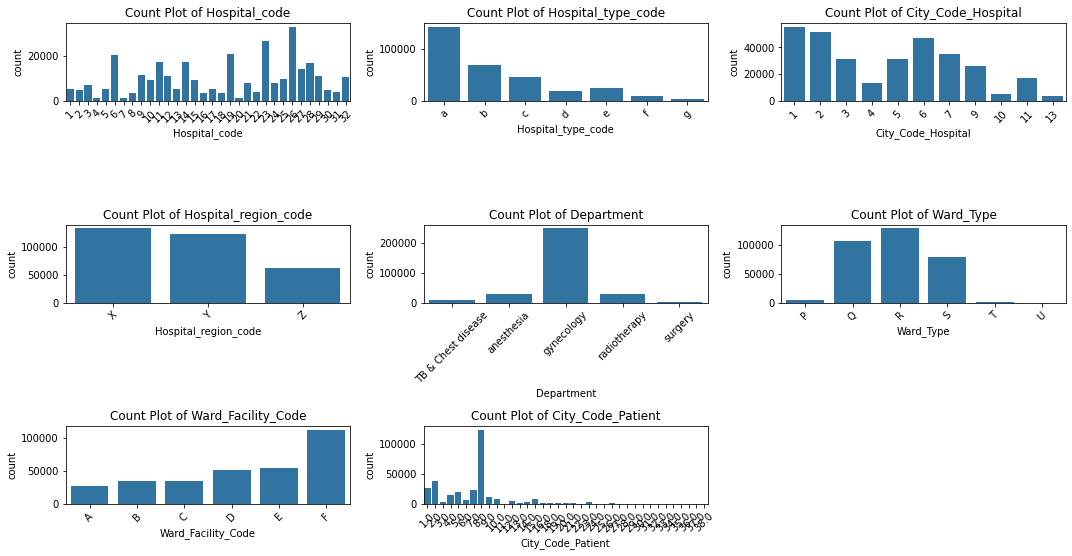

In [31]:
# Select categorical columns
cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Set figure size dynamically
plt.figure(figsize=(15, 10))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(4, 3, i)

    # Check if the categories are numeric-like and sort numerically
    unique_vals = train_data[col].dropna().unique()
    
    try:
        sorted_order = sorted(unique_vals, key=lambda x: float(x))
    except ValueError:
        sorted_order = sorted(unique_vals)

    sns.countplot(x=train_data[col], order=sorted_order)
    plt.xticks(rotation=45)
    plt.title(f'Count Plot of {col}')

plt.tight_layout()
plt.show()

The count plots display the distribution of various categorical hospital-related variables. Hospital codes are widely dispersed. Hospital type codes show that type 0 is the most common, while other types have significantly lower counts. City codes for hospitals and patients exhibit a skewed distribution, where a few codes dominate the dataset. Hospital region codes indicate that regions 0 and 1 have the highest patient distribution, while region 2 is less frequent. Departments are heavily imbalanced, with one department (coded as 2 which is Gynecology) accounting for the majority of patients. Ward types are unevenly distributed, with types 1, 2, and 3 being the most common. Ward facility codes increase in frequency as the code number rises, with facility 5 being the most prevalent. These trends suggest significant disparities in hospital, ward, and department utilization, which may impact patient distribution and hospital workload.

Some codes do not feature some numbesr: City Code Patient does not have 17, and City Code Hospital does not have 8 nor 12.

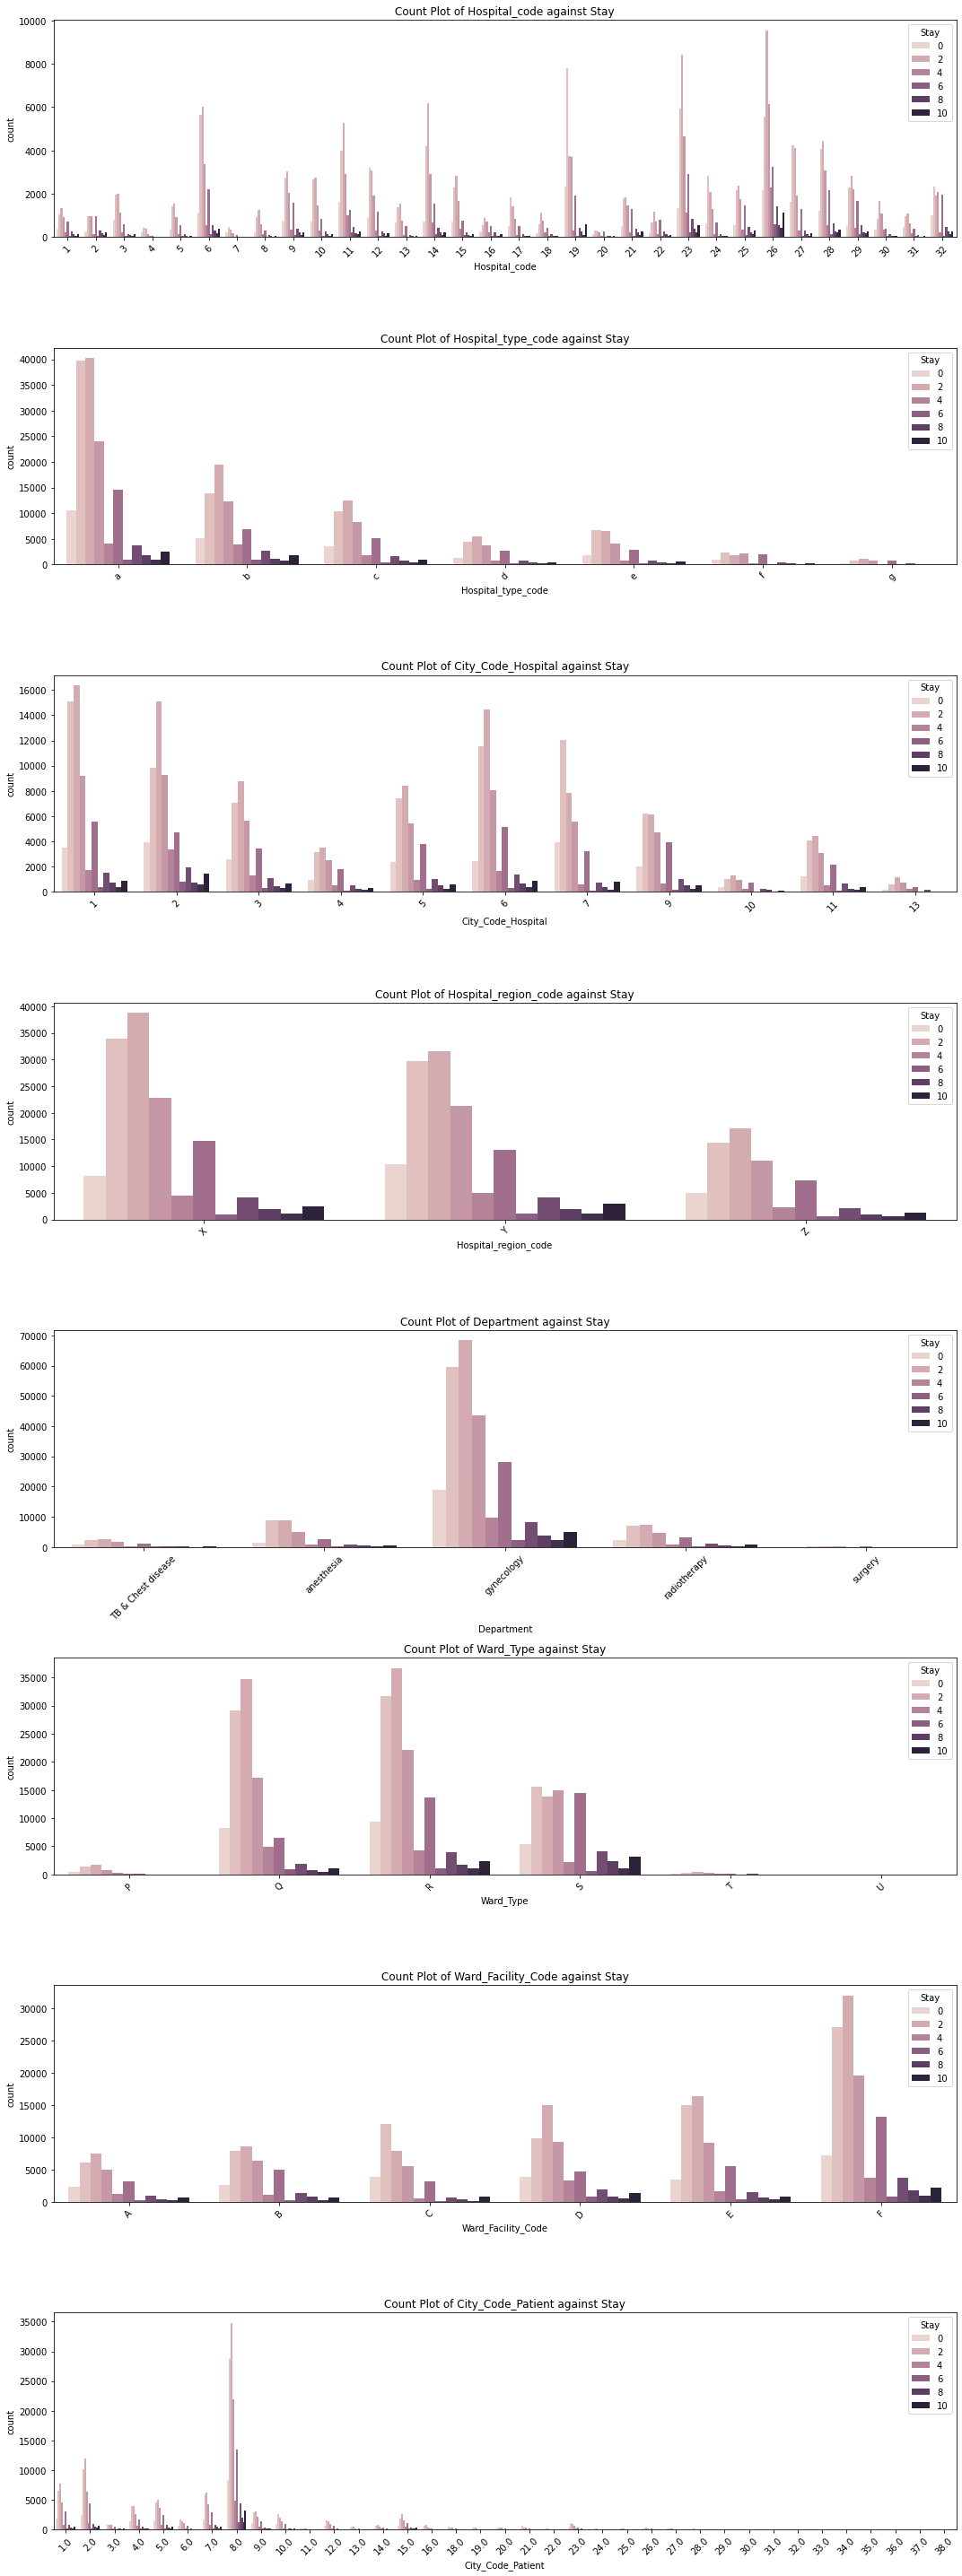

In [32]:
# Select categorical columns
cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Set figure size dynamically based on the number of categories
plt.figure(figsize=(15, 5 * len(cat_cols)))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(len(cat_cols), 1, i)

    # Extract unique values and attempt to sort them numerically
    unique_vals = train_data[col].dropna().unique()
    
    try:
        sorted_order = sorted(unique_vals, key=lambda x: float(x))  # Numeric sorting
    except ValueError:
        sorted_order = sorted(unique_vals)  # Default to alphabetical if non-numeric

    sns.countplot(x=train_data[col], hue=train_data['Stay'], order=sorted_order)
    plt.xticks(rotation=45)
    plt.title(f'Count Plot of {col} against Stay')

plt.tight_layout()
plt.show()

We plot each Stay per value for each column. However, because lower Stays, especially Stay = 2, dominates the data set, it is difficult for us to extract meaningful details. There are no obvious insights, so we next choose a percentage-based system in order to mitigate the effects of the data imbalance for our visualiations.

In [33]:
# Select categorical columns for chi-square testing
cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Function to compute Cramér’s V

def cramers_v(chi2, n, min_dim):
    return np.sqrt(chi2 / (n * (min_dim - 1)))

chi_square_results = {}
cramers_v_results = {}

for col in cat_cols:
    contingency_table = pd.crosstab(train_data[col], train_data['Stay'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[col] = p  # Store p-value
    cramers_v_results[col] = cramers_v(chi2, train_data.shape[0], min(contingency_table.shape))

# Convert results to DataFrame
chi_square_df = pd.DataFrame({
    'Feature': list(chi_square_results.keys()),
    'Chi-Square P-Value': list(chi_square_results.values()),
    "Cramer's V": list(cramers_v_results.values())
}).sort_values(by="Cramer's V", ascending=False)

# Display chi-square test results
print("\nStatistical Analysis for Categorical Variables:")
print(chi_square_df)


Statistical Analysis for Categorical Variables:
                Feature  Chi-Square P-Value  Cramer's V
5             Ward_Type        0.000000e+00    0.107651
0         Hospital_code        0.000000e+00    0.075192
6    Ward_Facility_Code        0.000000e+00    0.068667
1    Hospital_type_code        0.000000e+00    0.053851
2    City_Code_Hospital        0.000000e+00    0.051597
3  Hospital_region_code       2.107242e-245    0.043706
7     City_Code_Patient        0.000000e+00    0.036786
4            Department        0.000000e+00    0.035651


Ward Type and Hospital Code have the highest Cramer's V with 0.107 and 0.075, suggesting some correlation. However, these numbers are still low, so the correlation is very minor. Chi Sqare P-Value did not tell us much information as most are virtually 0.

In [34]:
def plot_categorical_proportion(train_data, category_col):
    if category_col not in train_data.columns:
        print(f"Column '{category_col}' not found in dataset.")
        return
    
    # Compute proportions (normalize=True gives percentages)
    category_counts = train_data.groupby("Stay")[category_col].value_counts(normalize=True).unstack() * 100

    # Sort the column values numerically if possible
    try:
        sorted_order = sorted(category_counts.columns, key=lambda x: float(x))
        category_counts = category_counts[sorted_order]
    except ValueError:
        pass  # If non-numeric, default sorting applies

    # Plot stacked bar chart
    plt.figure(figsize=(10, 6))
    category_counts.plot(kind='bar', stacked=True, color=sns.color_palette("pastel"), figsize=(10, 6))
    
    # Formatting
    plt.title(f"Percentage Distribution of {category_col} by Stay")
    plt.xlabel("Stay Duration")
    plt.ylabel("Percentage of Total Stay")
    plt.legend(title=category_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    
    # Show plot
    plt.show()

<Figure size 720x432 with 0 Axes>

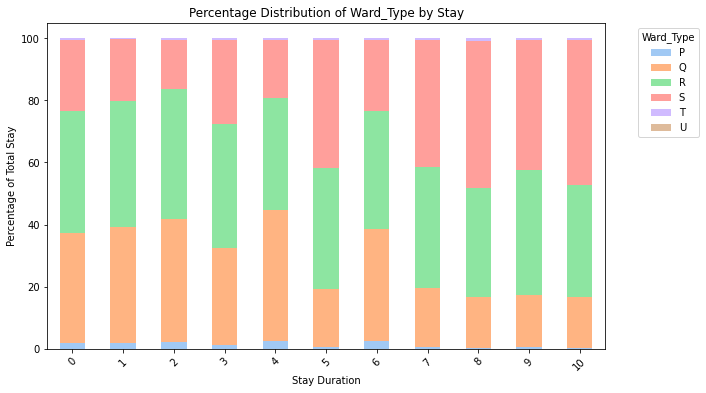

<Figure size 720x432 with 0 Axes>

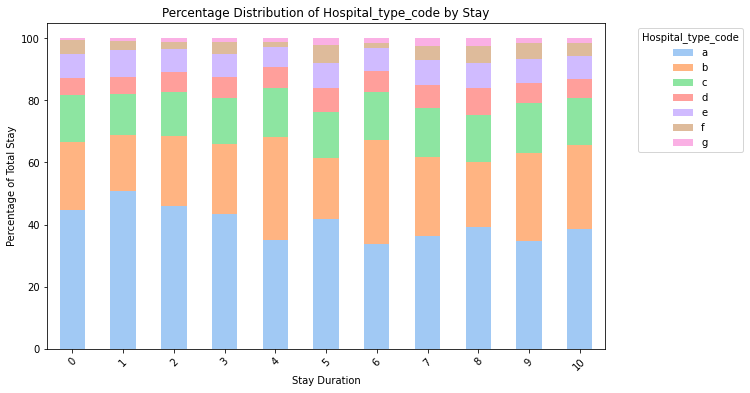

<Figure size 720x432 with 0 Axes>

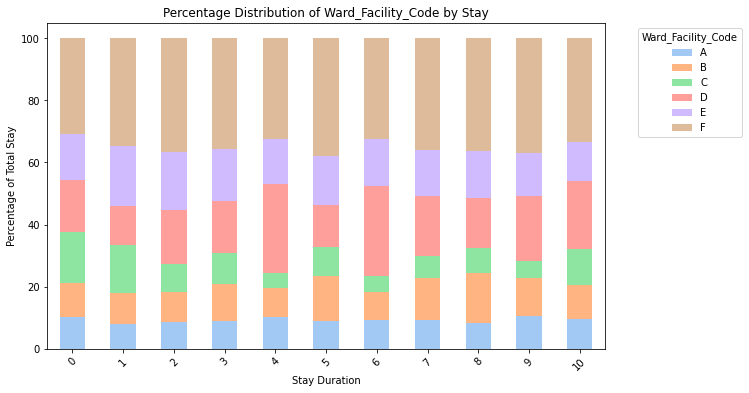

Column 'Hospital_type_code ' not found in dataset.


<Figure size 720x432 with 0 Axes>

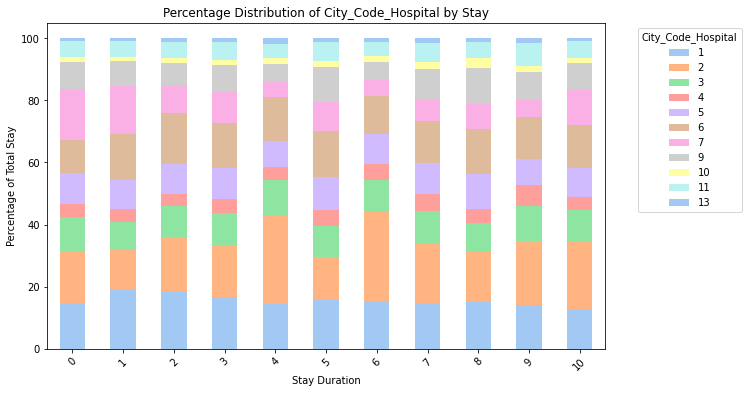

<Figure size 720x432 with 0 Axes>

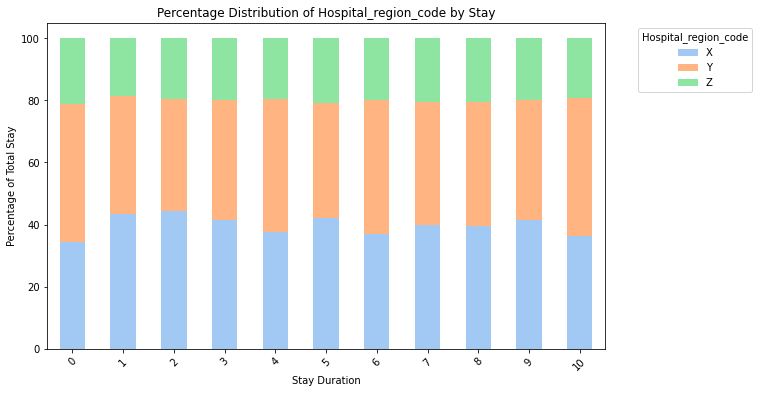

<Figure size 720x432 with 0 Axes>

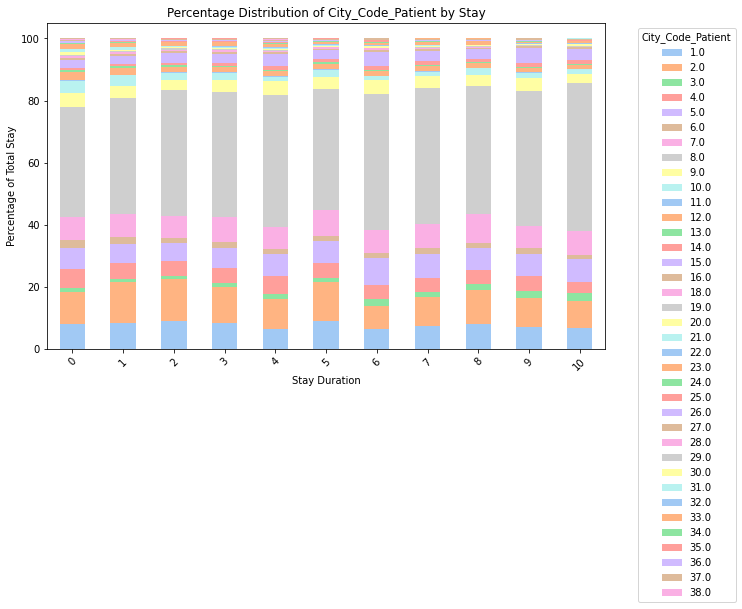

<Figure size 720x432 with 0 Axes>

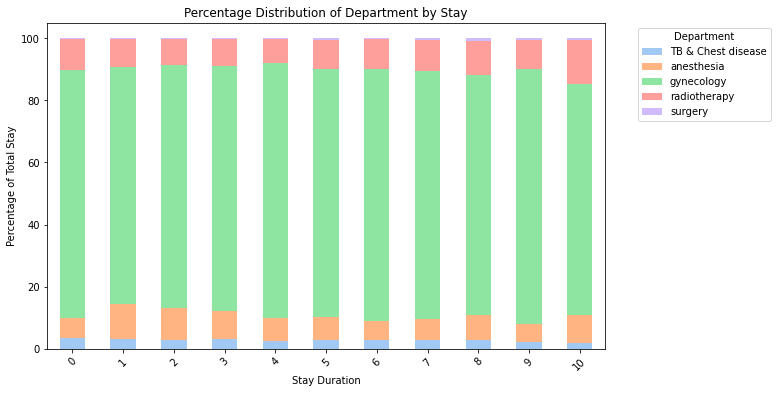

In [35]:
plot_categorical_proportion(train_data, "Ward_Type")
plot_categorical_proportion(train_data, "Hospital_type_code")
plot_categorical_proportion(train_data, "Ward_Facility_Code")
plot_categorical_proportion(train_data, "Hospital_type_code ")
plot_categorical_proportion(train_data, "City_Code_Hospital")
plot_categorical_proportion(train_data, "Hospital_region_code")
plot_categorical_proportion(train_data, "City_Code_Patient")
plot_categorical_proportion(train_data, "Department")

We plot the percentage distributions for each category and stay in order of the highest to lower Cramer's V to show the explain the minor correlations suggested by those statistics. While most plots featured all mostly-identical columns, Ward_Type and City_Code have some differences among types. For example, patients with longer stays slightly tend to stay in Ward S, while patients with shorter stays slightly tend to stay in Wards R or Q. Furthermore, patients with a Stay of 4 or 6 periods slightly tend to stay in City Code Hospital 2 and less likely to stay in City Code Hospital 7 than compared to other Stay lengths. This shows that Ward Type and City Code Hospital has minor correlation with Stay. For other attributes, there suggests to be no correlation.

Department makes sense to have low perctentage distributions because gynecology encompases most of the column, so it has a very high percentage for each Stay value. Hospital Region Code and City Code Patient also have minor discepenties between codes, suggesting lower correlation between different codes and certains Stay.



# Analysis Between Hospital Codes

In [36]:
# One-hot encode categorical columns
categorical_codes = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Department', 'Ward_Facility_Code', 'Hospital_region_code', 'Ward_Type', 'City_Code_Patient', 'Stay']
train_data_encoded = pd.get_dummies(train_data, columns=categorical_codes, drop_first=False)

# Ensure all one-hot encoded categorical columns are included
encoded_cols = sorted([col for col in train_data_encoded.columns if col.startswith(tuple(categorical_codes))])

# Print all one-hot encoded column names, sorted alphabetically with new lines
print("One-hot encoded columns in train_data_encoded:")
for col in encoded_cols:
    print(col)

One-hot encoded columns in train_data_encoded:
City_Code_Hospital_1
City_Code_Hospital_10
City_Code_Hospital_11
City_Code_Hospital_13
City_Code_Hospital_2
City_Code_Hospital_3
City_Code_Hospital_4
City_Code_Hospital_5
City_Code_Hospital_6
City_Code_Hospital_7
City_Code_Hospital_9
City_Code_Patient_1.0
City_Code_Patient_10.0
City_Code_Patient_11.0
City_Code_Patient_12.0
City_Code_Patient_13.0
City_Code_Patient_14.0
City_Code_Patient_15.0
City_Code_Patient_16.0
City_Code_Patient_18.0
City_Code_Patient_19.0
City_Code_Patient_2.0
City_Code_Patient_20.0
City_Code_Patient_21.0
City_Code_Patient_22.0
City_Code_Patient_23.0
City_Code_Patient_24.0
City_Code_Patient_25.0
City_Code_Patient_26.0
City_Code_Patient_27.0
City_Code_Patient_28.0
City_Code_Patient_29.0
City_Code_Patient_3.0
City_Code_Patient_30.0
City_Code_Patient_31.0
City_Code_Patient_32.0
City_Code_Patient_33.0
City_Code_Patient_34.0
City_Code_Patient_35.0
City_Code_Patient_36.0
City_Code_Patient_37.0
City_Code_Patient_38.0
City_Code

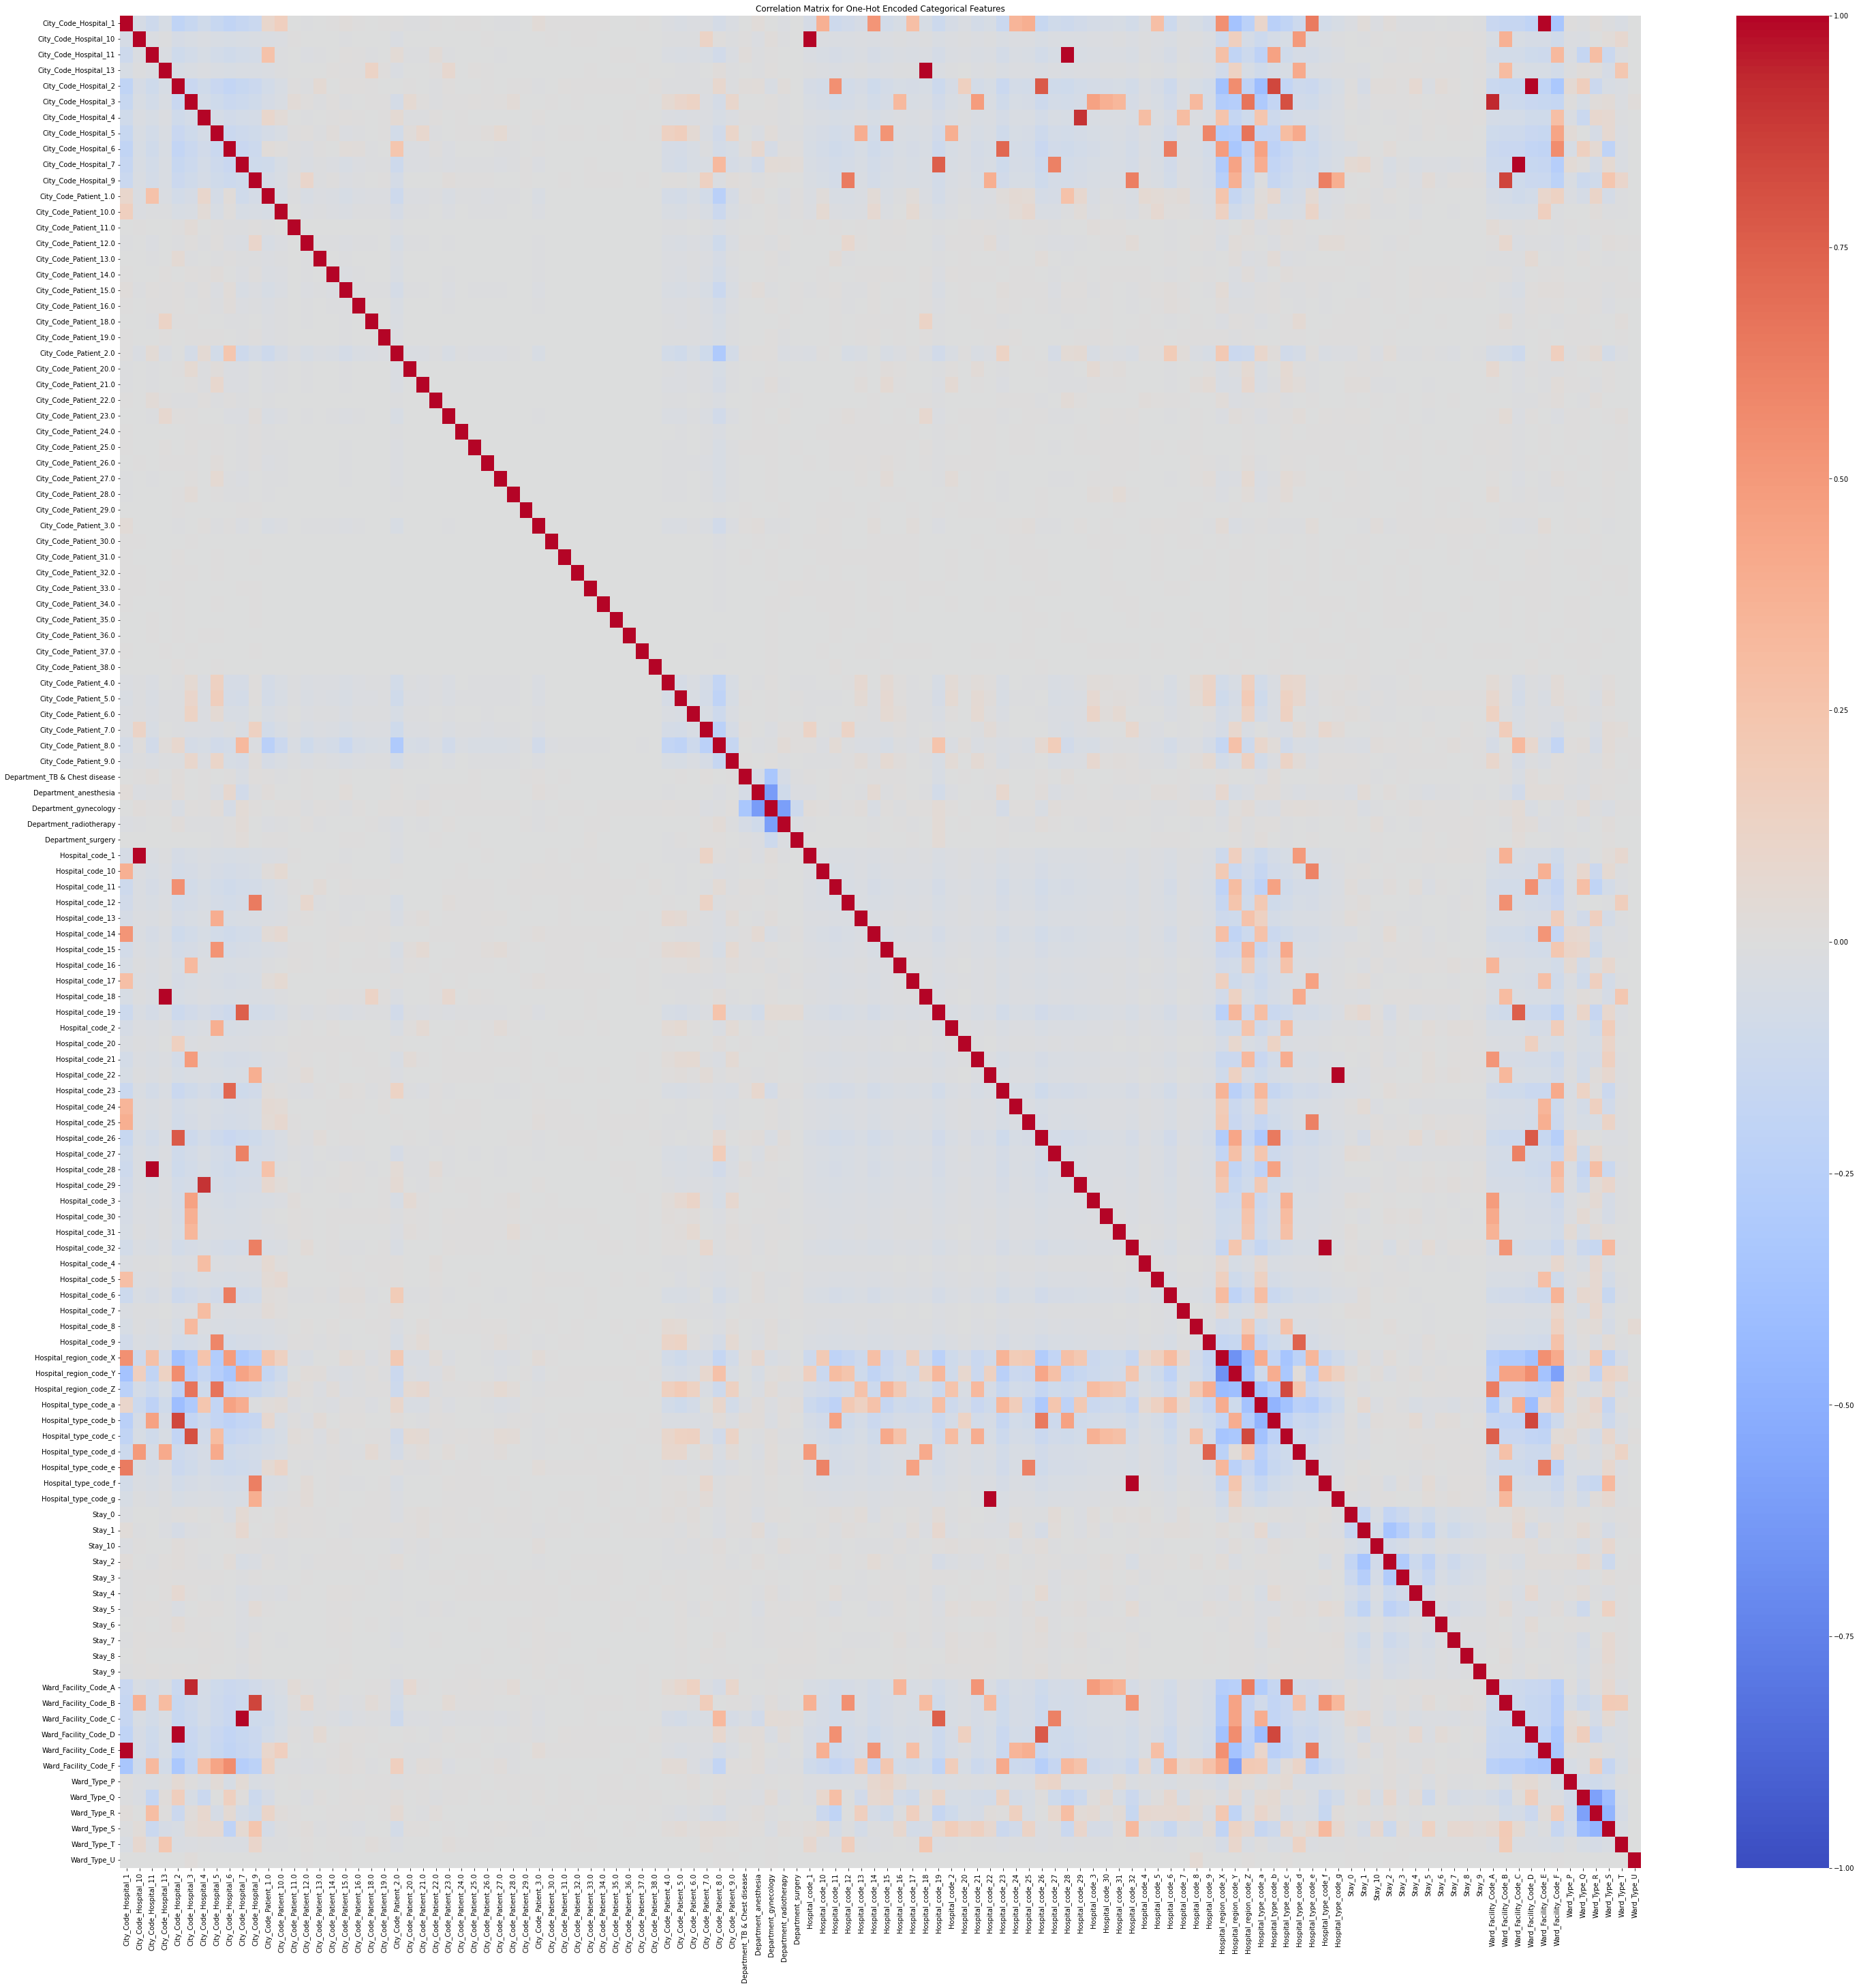

In [37]:
# Compute correlation matrix
correlation_matrix = train_data_encoded.corr()

# Filter only the one-hot encoded categorical columns
encoded_cols = sorted([col for col in train_data_encoded.columns if any(code in col for code in categorical_codes)])
correlation_matrix= correlation_matrix.loc[encoded_cols, encoded_cols]

plt.figure(figsize=(50, 50))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix for One-Hot Encoded Categorical Features")
plt.show()

Some Hospital_code values are highly correlated with City_Code_Hospital. This suggests that certain hospitals are strongly associated with specific cities. 	Hospital_type_code and City_Code_Hospital also show strong correlations, indicating that hospital types are not uniformly distributed across cities. There are correlations between Hospital_code and Hospital_region_code, meaning that some hospitals are dominant in specific regions.

In [38]:
# Filter correlations for "Stay" columns
stay_correlations = correlation_matrix.filter(like="Stay", axis=0).apply(lambda x: x[abs(x) > 0.1])

# Remove correlations between different "Stay" categories
stay_correlations = stay_correlations.drop(columns=[col for col in stay_correlations.columns if "Stay" in col], errors='ignore')

# Drop NaN values to show only relevant correlations
stay_correlations = stay_correlations.dropna(axis=1, how='all')

# Print the filtered correlations
print(stay_correlations)

         Ward_Type_Q  Ward_Type_S
Stay_0           NaN          NaN
Stay_1           NaN          NaN
Stay_10          NaN          NaN
Stay_2           NaN    -0.122992
Stay_3           NaN          NaN
Stay_4           NaN          NaN
Stay_5     -0.110034     0.136599
Stay_6           NaN          NaN
Stay_7           NaN          NaN
Stay_8           NaN          NaN
Stay_9           NaN          NaN


In [39]:
# Extract all pairs with absolute correlation > 0.4 (excluding self-correlations)
correlation_threshold = 0.4
correlation_pairs = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_correlation_pairs = correlation_pairs[correlation_pairs['Correlation'].abs() > correlation_threshold]

# Sort by absolute correlation value
high_correlation_pairs = high_correlation_pairs.reindex(high_correlation_pairs['Correlation'].abs().sort_values(ascending=False).index)

# Disable truncation in Pandas
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns (if needed)
pd.set_option("display.expand_frame_repr", False)  # Prevent wrapping

# Print the entire sorted DataFrame
print(high_correlation_pairs)

                   Feature 1                Feature 2  Correlation
5654        Hospital_code_22     Hospital_type_code_g     1.000000
1115    City_Code_Hospital_7     Ward_Facility_Code_C     1.000000
109     City_Code_Hospital_1     Ward_Facility_Code_E     1.000000
168    City_Code_Hospital_10          Hospital_code_1     1.000000
566     City_Code_Hospital_2     Ward_Facility_Code_D     1.000000
303    City_Code_Hospital_11         Hospital_code_28     1.000000
6137        Hospital_code_32     Hospital_type_code_f     1.000000
406    City_Code_Hospital_13         Hospital_code_18     1.000000
675     City_Code_Hospital_3     Ward_Facility_Code_A     0.934250
754     City_Code_Hospital_4         Hospital_code_29     0.899722
1221    City_Code_Hospital_9     Ward_Facility_Code_B     0.851308
546     City_Code_Hospital_2     Hospital_type_code_b     0.838538
6516    Hospital_type_code_b     Ward_Facility_Code_D     0.838538
6440  Hospital_region_code_Z     Hospital_type_code_c     0.82

In [40]:
# Count occurrences of Hospital_code_29 and City_Code_Hospital_4
hospital_28_count = train_data_encoded['Hospital_code_28'].sum()
city_hospital_11_count = train_data_encoded['City_Code_Hospital_11'].sum()

# Cross-tabulation to see how many of each exist within the other
cross_tab = pd.crosstab(train_data_encoded['Hospital_code_28'], train_data_encoded['City_Code_Hospital_11'])

# Print results
print(f"Total occurrences of Hospital_code_28: {hospital_28_count}")
print(f"Total occurrences of City_Code_Hospital_11: {city_hospital_11_count}")
print("\nCross-tabulation of Hospital_code_28 vs City_Code_Hospital_11:")
print(cross_tab)

Total occurrences of Hospital_code_28: 17137
Total occurrences of City_Code_Hospital_11: 17137

Cross-tabulation of Hospital_code_28 vs City_Code_Hospital_11:
City_Code_Hospital_11   False  True 
Hospital_code_28                    
False                  301301      0
True                        0  17137


## Finish Data Cleaning

In [8]:
# Handle missing values by replacing with mode
if train_data['Bed Grade'].isnull().sum() > 0:
    train_data['Bed Grade'].fillna(train_data['Bed Grade'].mode()[0], inplace=True)
if train_data['City_Code_Patient'].isnull().sum() > 0:
    train_data['City_Code_Patient'].fillna(train_data['City_Code_Patient'].mode()[0], inplace=True)

# Ensure both columns remain as float64
train_data['Bed Grade'] = train_data['Bed Grade'].astype('float64')
train_data['City_Code_Patient'] = train_data['City_Code_Patient'].astype('float64')

In [9]:
label_encoders = {}

# Label Encode Department
if 'Department' in train_data.columns:
    le = LabelEncoder()
    train_data['Department'] = le.fit_transform(train_data['Department'])
    label_encoders['Department'] = le


In [10]:
# Convert categorical variables of codes and phrases to numbers
if 'Hospital_type_code' in train_data.columns:
    train_data['Hospital_type_code'] = train_data['Hospital_type_code'].map(lambda x: ord(x.lower()) - ord('a'))
if 'Ward_Facility_Code' in train_data.columns:
    train_data['Ward_Facility_Code'] = train_data['Ward_Facility_Code'].map(lambda x: ord(x) - ord('A'))
if 'Hospital_region_code' in train_data.columns:
    region_mapping = {'X': 0, 'Y': 1, 'Z': 2}
if 'Ward_Type' in train_data.columns:
    train_data['Ward_Type'] = train_data['Ward_Type'].map(lambda x: ord(x) - ord('P'))

In [11]:
# Define categorical columns
categorical_codes = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Department', 
                     'Ward_Facility_Code', 'Hospital_region_code', 'Ward_Type', 'City_Code_Patient']

# Convert categorical variables to string first
for col in categorical_codes:
    if col in train_data.columns:
        train_data[col] = train_data[col].astype(str)

# Ensure categorical values are treated as integers (to prevent float issues in column names)
for col in categorical_codes:
    if col in train_data.columns:
        train_data[col] = train_data[col].str.replace(r'\.0$', '', regex=True)  # Remove ".0" from values

# Apply one-hot encoding while keeping numerical columns
train_data = pd.get_dummies(train_data, columns=categorical_codes, drop_first=True, dtype=int)

# Ensure all encoded categorical columns are stored as integers
bool_cols = [col for col in train_data.columns if col.startswith(tuple(categorical_codes))]

# Convert only 0/1 columns to boolean
for col in bool_cols:
    if set(train_data[col].unique()).issubset({0, 1}):  
        train_data[col] = train_data[col].astype(bool)

# Count the number of True values in each boolean column
true_counts = train_data[bool_cols].sum()

# Get data types of each boolean column
col_types = train_data[bool_cols].dtypes

# Print results
print("Number of True values and data types in each categorical boolean column:\n")
print(pd.DataFrame({"True Count": true_counts, "Data Type": col_types}))

Number of True values and data types in each categorical boolean column:

                     True Count Data Type
Hospital_code_10           9435      bool
Hospital_code_11          17328      bool
Hospital_code_12          11297      bool
Hospital_code_13           5236      bool
Hospital_code_14          17328      bool
...                         ...       ...
City_Code_Patient_5       20079      bool
City_Code_Patient_6        6005      bool
City_Code_Patient_7       23807      bool
City_Code_Patient_8      128543      bool
City_Code_Patient_9       11795      bool

[99 rows x 2 columns]


In [12]:

num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
exclude_cols = ['Stay']
num_cols = [col for col in num_cols if col not in exclude_cols]

# Apply Min-Max Scaling
scaler = MinMaxScaler()
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])

# Print confirmation
print("Min-Max Scaling applied to the following columns:")
print(num_cols)

Min-Max Scaling applied to the following columns:
['Available Extra Rooms in Hospital', 'Bed Grade', 'Type of Admission', 'Severity of Illness', 'Visitors with Patient', 'Age', 'Admission_Deposit']


In [13]:
# Find all columns that start with any of the categorical codes
bool_cols = [col for col in train_data.columns if col.startswith(tuple(categorical_codes))]

# Ensure they only contain 0s and 1s before converting to bool
#for col in bool_cols:
#    unique_values = train_data[col].unique()
#    if set(unique_values).issubset({0, 1}):  # Convert only if values are 0 or 1
#        train_data[col] = train_data[col].astype(bool)

# Count the number of True values in each boolean column
true_counts = train_data[bool_cols].sum()

# Get all columns that start with any categorical code
bool_cols = [col for col in train_data.columns if col.startswith(tuple(categorical_codes))]

# Convert these columns to boolean (if they aren't already)
train_data[bool_cols] = train_data[bool_cols].astype(bool)

# Count the number of True values in each boolean column
true_counts = train_data[bool_cols].sum()

# Get the data types of each column
col_types = train_data[bool_cols].dtypes

# Print results
print("Number of True values and data types in each categorical boolean column:\n")
print(pd.DataFrame({"True Count": true_counts, "Data Type": col_types}))


Number of True values and data types in each categorical boolean column:

                     True Count Data Type
Hospital_code_10           9435      bool
Hospital_code_11          17328      bool
Hospital_code_12          11297      bool
Hospital_code_13           5236      bool
Hospital_code_14          17328      bool
...                         ...       ...
City_Code_Patient_5       20079      bool
City_Code_Patient_6        6005      bool
City_Code_Patient_7       23807      bool
City_Code_Patient_8      128543      bool
City_Code_Patient_9       11795      bool

[99 rows x 2 columns]


In [14]:
# Save the cleaned dataset to a CSV file
train_data.to_csv("train_cleaned.csv", index=False)

## Analysis of Final Cleaned Data

In [48]:
print(train_data.info())

# Display the new shape of encoded data
print("Shape after encoding:", train_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Columns: 107 entries, Available Extra Rooms in Hospital to City_Code_Patient_9
dtypes: bool(99), float64(7), int64(1)
memory usage: 49.5 MB
None
Shape after encoding: (318438, 107)


In [49]:
# Summary Statistics
print("\nSummary Statistics:")
print(train_data.describe())


Summary Statistics:
       Available Extra Rooms in Hospital      Bed Grade  Type of Admission  Severity of Illness  Visitors with Patient            Age  Admission_Deposit           Stay
count                      318438.000000  318438.000000      318438.000000        318438.000000          318438.000000  318438.000000      318438.000000  318438.000000
mean                            0.133234       0.541862           0.445696             0.454231               0.102628       0.458642           0.334573       2.698550
std                             0.048674       0.291023           0.457137             0.331443               0.055127       0.209952           0.118025       2.150075
min                             0.000000       0.000000           0.000000             0.000000               0.000000       0.000000           0.000000       0.000000
25%                             0.083333       0.333333           0.000000             0.000000               0.062500       0.333333      

In [50]:
# Basic Info
print("Basic Dataset Info:")
print(train_data.info())

Basic Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Columns: 107 entries, Available Extra Rooms in Hospital to City_Code_Patient_9
dtypes: bool(99), float64(7), int64(1)
memory usage: 49.5 MB
None


In [51]:
train_data.head()

,Available Extra Rooms in Hospital,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,Hospital_code_10,Hospital_code_11,Hospital_code_12,Hospital_code_13,Hospital_code_14,Hospital_code_15,Hospital_code_16,Hospital_code_17,Hospital_code_18,Hospital_code_19,Hospital_code_2,Hospital_code_20,Hospital_code_21,Hospital_code_22,Hospital_code_23,Hospital_code_24,Hospital_code_25,Hospital_code_26,Hospital_code_27,Hospital_code_28,Hospital_code_29,Hospital_code_3,Hospital_code_30,Hospital_code_31,Hospital_code_32,Hospital_code_4,Hospital_code_5,Hospital_code_6,Hospital_code_7,Hospital_code_8,Hospital_code_9,Hospital_type_code_1,Hospital_type_code_2,Hospital_type_code_3,Hospital_type_code_4,Hospital_type_code_5,Hospital_type_code_6,City_Code_Hospital_10,City_Code_Hospital_11,City_Code_Hospital_13,City_Code_Hospital_2,City_Code_Hospital_3,City_Code_Hospital_4,City_Code_Hospital_5,City_Code_Hospital_6,City_Code_Hospital_7,City_Code_Hospital_9,Department_1,Department_2,Department_3,Department_4,Ward_Facility_Code_1,Ward_Facility_Code_2,Ward_Facility_Code_3,Ward_Facility_Code_4,Ward_Facility_Code_5,Hospital_region_code_Y,Hospital_region_code_Z,Ward_Type_1,Ward_Type_2,Ward_Type_3,Ward_Type_4,Ward_Type_5,City_Code_Patient_10,City_Code_Patient_11,City_Code_Patient_12,City_Code_Patient_13,City_Code_Patient_14,City_Code_Patient_15,City_Code_Patient_16,City_Code_Patient_18,City_Code_Patient_19,City_Code_Patient_2,City_Code_Patient_20,City_Code_Patient_21,City_Code_Patient_22,City_Code_Patient_23,City_Code_Patient_24,City_Code_Patient_25,City_Code_Patient_26,City_Code_Patient_27,City_Code_Patient_28,City_Code_Patient_29,City_Code_Patient_3,City_Code_Patient_30,City_Code_Patient_31,City_Code_Patient_32,City_Code_Patient_33,City_Code_Patient_34,City_Code_Patient_35,City_Code_Patient_36,City_Code_Patient_37,City_Code_Patient_38,City_Code_Patient_4,City_Code_Patient_5,City_Code_Patient_6,City_Code_Patient_7,City_Code_Patient_8,City_Code_Patient_9
0,0.125000,0.333333,1.0,1.0,0.0625,0.555556,0.337858,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,0.083333,0.333333,0.0,1.0,0.0625,0.555556,0.451129,4,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,0.083333,0.333333,0.0,1.0,0.0625,0.555556,0.319831,3,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,0.083333,0.333333,0.0,1.0,0.0625,0.555556,0.594266,4,False,False,False,F